# Assignment 4

Deadline: 30.04.2025 12:00 CET

<Add your name, student-id and emal address>
* Zihan Liu, 22-736-938, zihan.liu@uzh.ch
* Yujie Tao, 23-744-378, yujie.tao@uzh.ch
* Weijie Chen, 23-743-727, weijie.chen@uzh.ch
* Schmidli Adrian, 17-728-833, adrian.schmidli@uzh.ch

## Prerequisites: Library imports, data load and initialization of the backtest service

In [1]:
# Standard library imports
import os
import sys
import copy
from typing import Union, Optional

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import empyrical as ep

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course\\src')    #<Change this path if needed>
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [2]:
# Load data
path_to_data = "C:/Users/admin/OneDrive/Dokumente/Studium UZH/Master/5. Semester/Quantitative Portfolio Management with Python/Assingments/4. Assingment/1. Daten erhalten/" # <change this if necessary>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path='../data/')  # <change this if necessary>
print("Market data:")
print(data.market_data.head())
print(data.market_data.tail())
print("Benchmark series (SPI Index):")
print(data.bm_series.head())
print(data.bm_series.tail())

Market data:
               price        mktcap  liquidity sector
date       id                                       
1999-05-06 1   461.0  1.235952e+09   129080.0   None
1999-05-07 1   455.0  1.219866e+09     4550.0   None
1999-05-10 1   455.0  1.219866e+09      910.0   None
1999-05-11 1   460.0  1.233271e+09     4600.0   None
1999-05-12 1   460.0  1.233271e+09      460.0   None
                    price      mktcap  liquidity sector
date       id                                          
2024-04-24 313   9.814924  20167830.0        0.0   None
2024-04-25 313   9.814924  20167830.0        0.0   None
2024-04-26 313   9.814924  20167830.0        0.0   None
2024-04-29 313  10.905471  22408700.0     2000.0   None
2024-04-30 313  10.905471  22408700.0        0.0   None
Benchmark series (SPI Index):
1999-01-02    0.000000
1999-01-03    0.000000
1999-01-04    0.034044
1999-01-05    0.012670
1999-01-06    0.015455
Name: SPI, dtype: float64
2024-04-26    0.008030
2024-04-27    0.000000
2024-04

In [3]:
# Define rebalancing dates
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
print(market_data_dates)

n_days = 21*3 # Rebalance every 3 months (21 trading days per month).
rebdates = market_data_dates[market_data_dates > '2015-01-01'][::n_days].strftime('%Y-%m-%d').tolist()
print(rebdates)

DatetimeIndex(['1985-12-31', '1986-01-01', '1986-01-02', '1986-01-03',
               '1986-01-06', '1986-01-07', '1986-01-08', '1986-01-09',
               '1986-01-10', '1986-01-13',
               ...
               '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
               '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='date', length=9979, freq=None)
['2015-01-02', '2015-04-01', '2015-06-29', '2015-09-24', '2015-12-22', '2016-03-18', '2016-06-15', '2016-09-12', '2016-12-08', '2017-03-07', '2017-06-02', '2017-08-30', '2017-11-27', '2018-02-22', '2018-05-22', '2018-08-17', '2018-11-14', '2019-02-11', '2019-05-09', '2019-08-06', '2019-11-01', '2020-01-29', '2020-04-27', '2020-07-23', '2020-10-20', '2021-01-15', '2021-04-14', '2021-07-12', '2021-10-07', '2022-01-04', '2022-04-01', '2022-06-29', '2022-09-26', '2022-12-22', '2023-03-21', '2023-06-16', '2023-09-13', '2023-12-11', '2

In [4]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3, # three years look-back window
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252, # one year look-back window.
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3, # three years look-back window.
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [5]:
class MaxSharpe(Optimization):

    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 solver_name: Optional[str] = None,
                 risk_free_rate: Optional[float] = None,
                 max_iter: Optional[int] = None,
                 initial_lambda: Optional[float] = None,
                 lambda_growth: Optional[float] = None,
                 **kwargs) -> None:
        
        if solver_name is None:
            solver_name = 'cvxopt'  # Set a default solver if not provided
        kwargs['solver_name'] = solver_name

        super().__init__(
            constraints=constraints,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return
        self.risk_free_rate = 0.0 if risk_free_rate is None else risk_free_rate # Assuming a default risk-free rate of 0% for simplicity.
        self.max_iter = 10 if max_iter is None else max_iter
        self.initial_lambda = 1.0 if initial_lambda is None else initial_lambda
        self.lambda_growth = 1.5 if lambda_growth is None else lambda_growth

    def set_objective(self, optimization_data: OptimizationData) -> None:
        X = optimization_data['return_series']
        covmat = self.covariance.estimate(X=X, inplace=False)
        mu = self.expected_return.estimate(X=X, inplace=False)
        excess_returns = mu - self.risk_free_rate
        self.objective = Objective(
            q = excess_returns * -1,
            P = covmat * 2,
        )
        return None

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical': # If the chosen solver is "analytical", we cannot use the iterative Sharpe maximization. We need a numerical solver (e.g., "cvxopt").
            raise ValueError("Analytical solver is not suitable for iterative Sharpe maximization.")
    
        best_weights = None
        best_sharpe = -float('inf')
        original_P = self.objective.coefficients['P'].copy()

        for _ in range(1, self.max_iter + 1):
            scaled_P = self.objective.coefficients['P'] * self.initial_lambda
            self.objective.coefficients['P'] = scaled_P # Temporarily modify the objective with scaled covariance.

            super().solve() # Solve mean-variance problem.

            # Retrieve weights from results
            weights_dict = self.results.get('weights')
            if weights_dict is None:
                continue
            weights = np.array([weights_dict[i] for i in self.constraints.ids])
            weights = pd.Series(weights, index=self.constraints.ids)

            # Compute portfolio return and volatility
            mu = self.objective.coefficients['q'] + self.risk_free_rate  # recall q = mu - rf
            port_return = float(mu @ weights)
            port_vol = float(np.sqrt(weights.T @ (original_P / 2) @ weights))

            # Compute Sharpe ratio
            sharpe = (port_return - self.risk_free_rate) / port_vol if port_vol > 0 else -float('inf')

            # Update best solution
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_weights = weights.copy()

            # Increase risk aversion (penalize risk more)
            self.initial_lambda *= self.lambda_growth

            # Restore original objective matrix
            self.objective.coefficients['P'] = original_P

        # Save best result found
        self.results.update({'weights': best_weights.to_dict() if best_weights is not None else {},'status': best_weights is not None,})
        # If "status" is "True", it means that the optimization was successful and the weights are available. If "status" is "False", it means that the optimization was not successful and no weights are available.
        return None

b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

In [6]:
bs.optimization = MaxSharpe(
    covariance = Covariance(method='pearson'), # <change this to your preferred method>
    expected_return = ExpectedReturn(method='geometric'), # <change this to your preferred method>
    solver_name = 'cvxopt', # <change this to your preferred solver>
    risk_free_rate = 0.0, # <change this to your preferred risk-free rate>
    max_iter = 10, # <change this to your preferred number of iterations>
    initial_lambda = 1.0, # <change this to your preferred initial lambda>
    lambda_growth = 1.5, # <change this to your preferred lambda growth factor>
    # <add any other parameters you need>
)
bs.prepare_rebalancing('2024-03-07')
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
Port_weights = pd.DataFrame(bs.optimization.results)

# Visualization of the portfolio weights in a table:
pd.set_option('display.max_rows', None) # Show all rows
pd.set_option('display.width', 1000) # Prevent line-wrapping
Port_weights['weights (%)'] = (Port_weights['weights'] * 100).round(4)
Port_weights_sorted = Port_weights.sort_values(by='weights (%)', ascending=False)
display(Port_weights_sorted[['weights (%)', 'status']])
print("Solver used:", bs.optimization.params.get('solver_name', 'unknown'))

,weights (%),status
252,2.0000,True
256,2.0000,True
29,2.0000,True
185,2.0000,True
191,2.0000,True
286,2.0000,True
2,2.0000,True
283,2.0000,True
279,2.0000,True
204,2.0000,True


Solver used: cvxopt


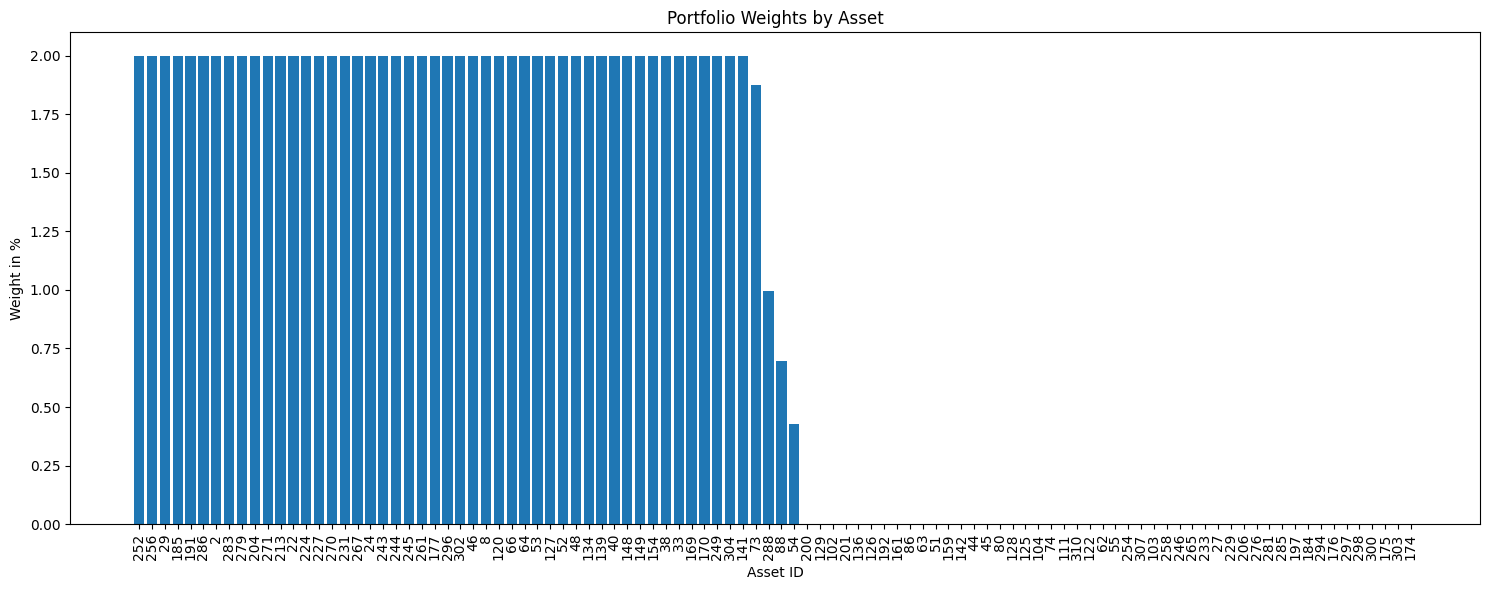

In [7]:
# Visualization of the portfolio weights in a plot:
plt.figure(figsize=(15, 6))
plt.bar(Port_weights_sorted.index, Port_weights_sorted.values[:,2])
plt.xticks(rotation=90)
plt.title("Portfolio Weights by Asset")
plt.xlabel("Asset ID")
plt.ylabel("Weight in %")
plt.tight_layout()
plt.show()

## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [18]:
target_turnover = 1.0 # 100%
tolerance = 0.01 # ±1% tolerance
best_penalty = None

penalty_values = np.arange(0, 2.01, 0.01)  # 0.00 to 2.00 inclusive, step 0.01

for penalty_value in penalty_values:
    bs.optimization = MaxSharpe(
        covariance = Covariance(method='pearson'),
        expected_return = ExpectedReturn(method='geometric'),
        solver_name ='cvxopt',
        risk_free_rate = 0.0,
        max_iter = 10,
        initial_lambda = 1.0,
        lambda_growth = 1.5,
        turnover_penalty = penalty_value
    )

    # Run backtest
    bt_ms = Backtest()
    bt_ms.run(bs=bs)

    # Compute annual turnover
    # Step 1: Get per-rebalance turnover values (raw, not annualized)
    turnover_series = bt_ms.strategy.turnover(return_series=bs.data.get_return_series(), rescale=False)
    # If rescale=True: turnover values (which are per rebalance) are rescaled to annual turnover.
    # If rescale=False: raw turnover per rebalance is returned.

    # Step 2: Estimate rebalancing frequency
    rebalancing_dates = [pd.to_datetime(date) for date in bt_ms.strategy.get_rebalancing_dates()]
    days = [(rebalancing_dates[i] - rebalancing_dates[i - 1]).days for i in range(1, len(rebalancing_dates))]
    avg_days_between_rebalances = np.mean(days)
    rebalances_per_year = 365 / avg_days_between_rebalances

    # Step 3: Compute true annualized turnover
    average_turnover_per_rebalance = turnover_series.mean()
    annual_turnover = average_turnover_per_rebalance * rebalances_per_year

    print(f"Penalty: {penalty_value:.2f}, Annual Turnover: {annual_turnover:.2%}")

    # Check if close to target
    if abs(annual_turnover - target_turnover) <= tolerance:
        best_penalty = penalty_value
        break

# Output result
if best_penalty is not None:
    print(f"\n✅ Best penalty: {best_penalty:.2f} (Annual turnover ≈ {target_turnover:.0%})")
else:
    print("\n❌ No suitable penalty found in range.")

Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


c:\Users\admin\OneDrive\Dokumente\Studium UZH\Master\5. Semester\Quantitative Portfolio Management with Python\Assingments\4. Assingment\2. Werkstatt\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
c:\Users\admin\OneDrive\Dokumente\Studium UZH\Master\5. Semester\Quantitative Portfolio Management with Python\Assingments\4. Assingment\2. Werkstatt\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


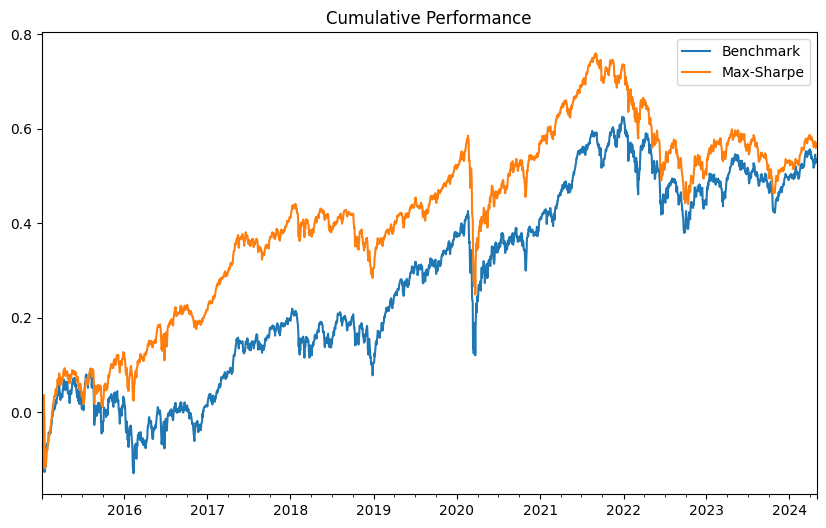

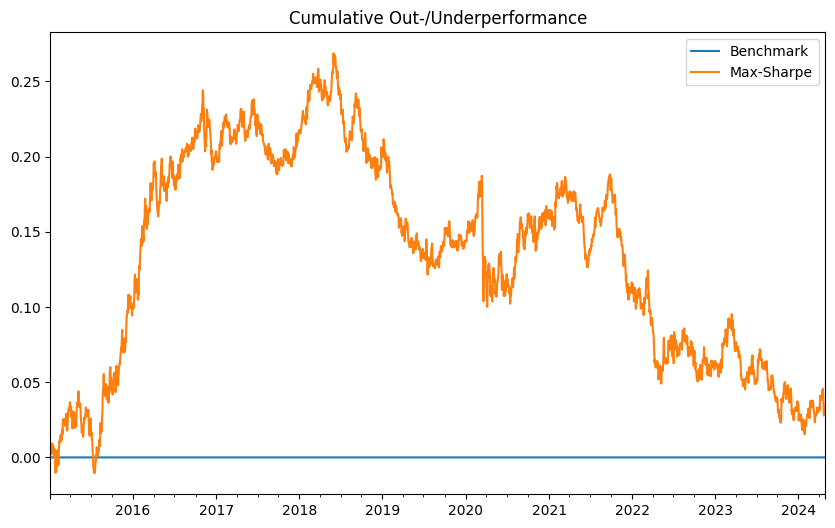

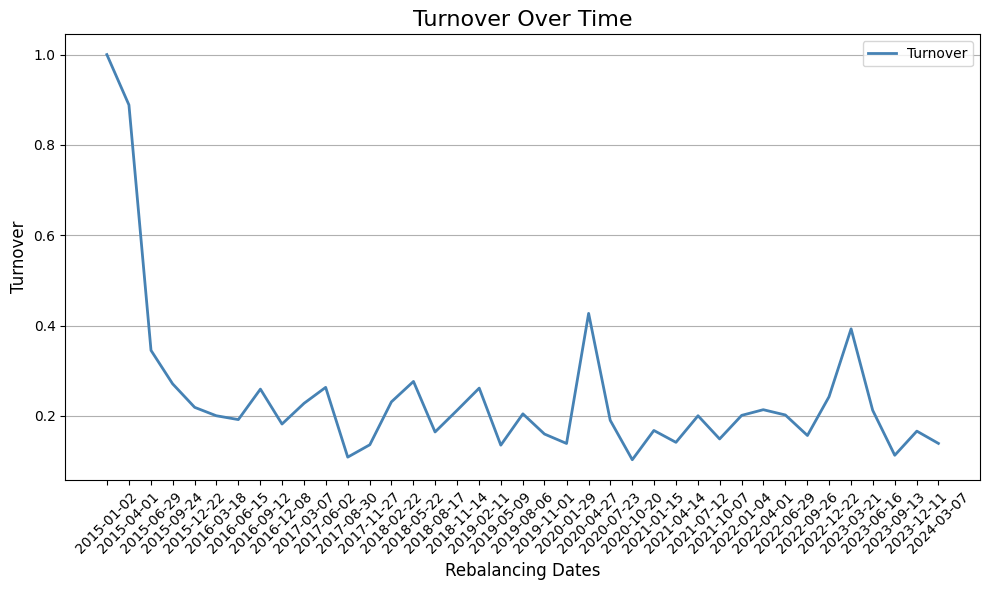

Annualized turnover:
1.007801602411576
Performance metrics for Benchmark
Performance metrics for Max-Sharpe


,Benchmark,Max-Sharpe
Annual Return,0.056593,0.060239
Cumulative Return,0.701100,0.758601
Annual Volatility,0.145690,0.125433
Sharpe Ratio,0.451148,0.529554
Max Drawdown,-0.263289,-0.285631
Tracking Error,0.000000,0.063467


In [19]:
# Simulate the portfolio returns from your "MaxSharpe" backtest:
fixed_costs = 0.01 # Fixed costs of 1%.
variable_costs = 0.003 # Variable costs of 0.3%.
return_series = bs.data.get_return_series()

sim_ms = bt_ms.strategy.simulate(return_series=return_series, fc=fixed_costs, vc=variable_costs)

# Plot the cumulated returns of the "MaxSharpe" strategy together with those of the SPI Index:
# Out-/Underperformance
def sim_outperformance(x: pd.DataFrame, y: pd.Series) -> pd.Series:
    ans = (x.subtract(y, axis=0)).divide(1 + y, axis=0)
    return ans

# Concatenate the simulations
sim = pd.concat({
    'bm': data.bm_series,
    'mv': sim_ms,
}, axis = 1).dropna()
sim.columns = ['Benchmark', 'Max-Sharpe']

# Plot the cumulative performance
np.log((1 + sim)).cumsum().plot(title='Cumulative Performance', figsize = (10, 6))

# Plot the cumulative out-/underperformance
sim_rel = sim_outperformance(sim, sim['Benchmark'])
np.log((1 + sim_rel)).cumsum().plot(title='Cumulative Out-/Underperformance', figsize = (10, 6))

# Plot the turnover of your "MaxSharpe" strategy over time:
turnover_series.index = pd.to_datetime(turnover_series.index) # Ensure datetime index
plt.figure(figsize=(10, 6))
plt.plot(turnover_series.index, turnover_series.values, label="Turnover", linewidth=2, color='steelblue')
plt.title("Turnover Over Time", fontsize=16)
plt.xlabel("Rebalancing Dates", fontsize=12)
plt.ylabel("Turnover", fontsize=12)
plt.xticks(ticks=turnover_series.index, labels=turnover_series.index.strftime('%Y-%m-%d'), rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

# Print the annualized turnover for your "MaxSharpe" strategy:
print("Annualized turnover:")
print(annual_turnover)

# Create and print a table with descriptive performance statistics for your "MaxSharpe" strategy and the SPI Index:
annual_return = {}
cumulative_returns = {}
annual_volatility = {}
sharpe_ratio = {}
max_drawdown = {}
tracking_error = {}
for column in sim.columns:
    print(f'Performance metrics for {column}')
    annual_return[column] = ep.annual_return(sim[column])
    cumulative_returns[column] = ep.cum_returns(sim[column]).tail(1).values[0]
    annual_volatility[column] = ep.annual_volatility(sim[column])
    sharpe_ratio[column] = ep.sharpe_ratio(sim[column])
    max_drawdown[column] = ep.max_drawdown(sim[column])
    tracking_error[column] = ep.annual_volatility(sim[column] - sim['Benchmark'])


annual_returns = pd.DataFrame(annual_return, index=['Annual Return'])
cumret = pd.DataFrame(cumulative_returns, index=['Cumulative Return'])
annual_volatility = pd.DataFrame(annual_volatility, index=['Annual Volatility'])
sharpe  = pd.DataFrame(sharpe_ratio, index=['Sharpe Ratio'])
mdd = pd.DataFrame(max_drawdown, index=['Max Drawdown'])
tracking_error = pd.DataFrame(tracking_error, index=['Tracking Error'])
pd.concat([annual_returns, cumret, annual_volatility, sharpe, mdd, tracking_error])